In [1]:
from functools import partial
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder


sys.path.append('../src')

from columnar import train, mte, report

%load_ext autoreload
%autoreload 2

# Testing Mean Target Encoding vs categorical data embeddings
## Task
Predict whether an adult's income is higher or lower than $50k, using census information

### Definitions
* **Mean Target Encoding** is a technique to transform categorical data into numerical by replacing the categorical value by the mean target value for all observations belonging to that category.
* **Categorical data embeddings** is a potentially more expresive generalization of MTE which consists in expressing each categorical value as an embedding. embeddings sizes can be defined based on the cardinality of each feature. An embedding of size 1 should replicate closely the principle of MTE (even though values are learnt more indireclty), but

### Dataset
We are leveraging the Adult dataset, which provides various census features about individuals and aims to predict whether an individual is earning over $50k or not.
[https://archive.ics.uci.edu/ml/datasets/Adult](https://archive.ics.uci.edu/ml/datasets/Adult)
## Load Data

In [2]:
COL_NAMES = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital-status', 'occupation',
             'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours-per-week', 'native-country', 'income']
df = pd.read_csv('../data/raw/adult.data', header=None)
df.columns = COL_NAMES
df['target'] = (df.income.str.strip() == '>50K')
df.sample(5)

,age,workclass,fnlwgt,education,education_num,marital-status,occupation,relationship,race,sex,capital_gain,capital_loss,hours-per-week,native-country,income,target
19074,28,Local-gov,296537,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,45,United-States,<=50K,False
12975,90,Private,250832,10th,6,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,<=50K,False
8930,47,Private,47496,HS-grad,9,Divorced,Craft-repair,Not-in-family,White,Male,0,0,42,United-States,<=50K,False
911,38,Private,278924,Some-college,10,Divorced,Craft-repair,Not-in-family,White,Male,0,0,44,United-States,<=50K,False
3628,22,Private,203182,Bachelors,13,Never-married,Exec-managerial,Other-relative,White,Female,0,0,20,United-States,<=50K,False


## Define Metrics for Success

In [3]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
def reporting(y_test, y_preds):
    return {
        'acc': accuracy_score(y_test, y_preds),
        'f1': f1_score(y_test, y_preds),
        'auc': roc_auc_score(y_test, y_preds),
    }

reporter = report.Report()
# 
reporter.set_columns_to_show(['encoder', 'acc', 'f1', 'auc'])

## Define Cross Validation Strategy

In [4]:
# cross validation strategy
kf = KFold(n_splits=5)

fit_and_score = partial(train.fit_and_score, 
                            kf=kf, 
                            data=df, 
                            reporting=reporting, 
                           )

## Feature Selection and Processing
* encode categorical variables using mean target encoding
* pass through all numerical variables

In [5]:
numericals = df.select_dtypes(np.number).columns.tolist()
categoricals = df.select_dtypes('object').columns.tolist()
categoricals.remove('income')
print(numericals, categoricals, sep='\n')

['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours-per-week']
['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']


In [6]:
# select features to use in the model
feature_selection = {'categoricals': categoricals,
                     'numericals': numericals,
                     'target': 'target'}

## Model Selection and Fitting

In [7]:
def fit_encoder_and_report(encoder, model, reporter):

    # define estimator
    config = train.Config(**feature_selection,
                          encoder=encoder,                          
                          model=model,
                             )


    pipe, results = fit_and_score(config)

    # performance for each fold
    display(results)

    # average results over cross-validation folds
    reporter.add_to_report(config, results.mean())
    display(reporter.show())
    
    return config, pipe, results

# define fitting function
mte_encoder = mte.MeanTargetEncoder(target=feature_selection['target'],
              categoricals=feature_selection['categoricals'])

mte_config, pipe, mte_results = fit_encoder_and_report(encoder=mte_encoder, 
                                                       model=RandomForestClassifier(n_estimators=100, max_depth=5),
                                                       reporter=reporter
                                                      )

,acc,f1,auc
0,0.846461,0.613003,0.729646
1,0.853655,0.625540,0.737281
2,0.855037,0.633825,0.742360
3,0.855805,0.642013,0.746222
4,0.849509,0.630746,0.739474


,encoder,acc,f1,auc
0,"MeanTargetEncoder(target=target, status=not_fi...",0.852093,0.629025,0.738997


## Compare to Baseline
### Baseline 1: Assign all predictions to majority class

In [8]:
# baseline: assign all predictions to majority class
maj_results = pd.Series(reporting(df.target, np.zeros(len(df))))
maj_config = train.Config(**feature_selection,
                         encoder='MajorityClass',
                         model='Nonę')

reporter.add_to_report(maj_config, maj_results)
reporter.show()

,encoder,acc,f1,auc
0,"MeanTargetEncoder(target=target, status=not_fi...",0.852093,0.629025,0.738997
1,MajorityClass,0.759190,0.000000,0.500000


## Baseline 2: one hot encode all categories

In [9]:
# define fitting function
ohe_encoder = OneHotEncoder(handle_unknown='ignore')

ohe_config, _, ohe_results = fit_encoder_and_report(encoder=ohe_encoder, 
                                                       model=RandomForestClassifier(n_estimators=100, max_depth=5),
                                                       reporter=reporter
                                                      )

,acc,f1,auc
0,0.834945,0.564601,0.701453
1,0.837684,0.551929,0.694389
2,0.838759,0.545455,0.690159
3,0.837224,0.539130,0.686115
4,0.835842,0.557350,0.695858


,encoder,acc,f1,auc
0,"MeanTargetEncoder(target=target, status=not_fi...",0.852093,0.629025,0.738997
1,MajorityClass,0.759190,0.000000,0.500000
2,OneHotEncoder(handle_unknown='ignore'),0.836891,0.551693,0.693595


## Baseline 3: LabelEncoder

In [10]:
# define fitting function
ord_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

_, _, ord_results = fit_encoder_and_report(encoder=ord_encoder, 
                                           model=RandomForestClassifier(n_estimators=100, max_depth=5),
                                           reporter=reporter,
                                          )

,acc,f1,auc
0,0.843237,0.595964,0.719063
1,0.852426,0.610458,0.726860
2,0.855037,0.624204,0.735033
3,0.851198,0.619851,0.731975
4,0.852273,0.634498,0.740885


,encoder,acc,f1,auc
0,"MeanTargetEncoder(target=target, status=not_fi...",0.852093,0.629025,0.738997
1,MajorityClass,0.759190,0.000000,0.500000
2,OneHotEncoder(handle_unknown='ignore'),0.836891,0.551693,0.693595
3,OrdinalEncoder(handle_unknown='use_encoded_val...,0.850834,0.616995,0.730763


## Inspect MTE output

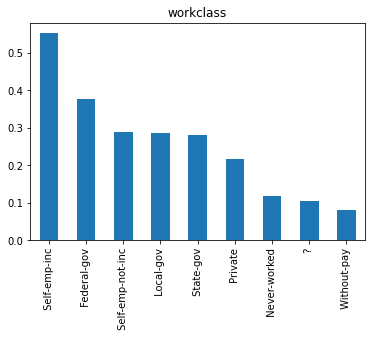

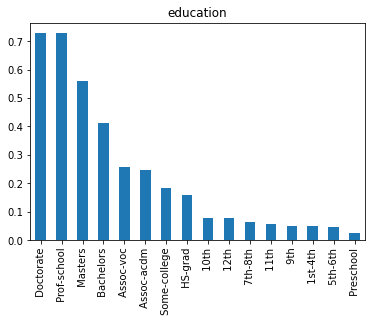

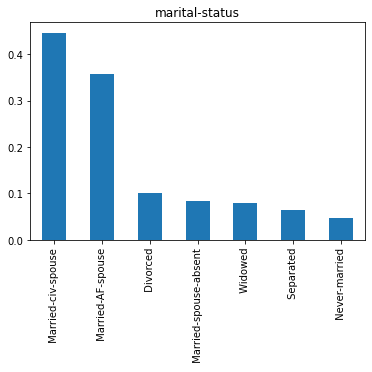

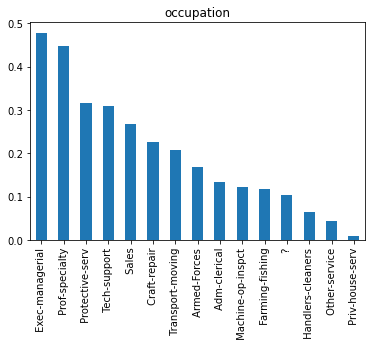

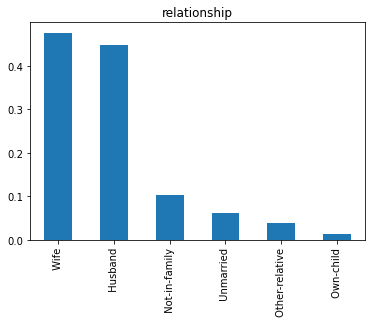

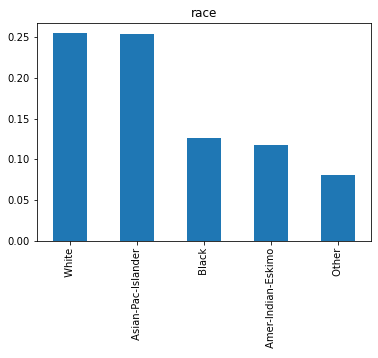

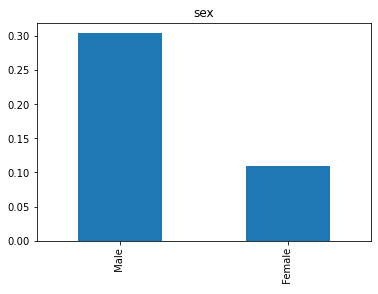

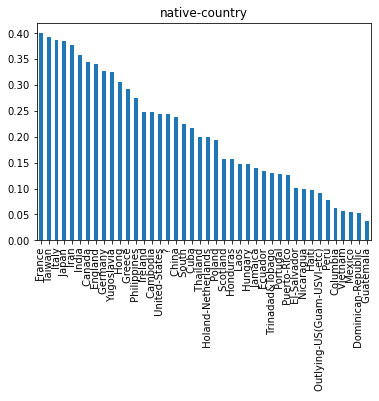

In [11]:
# get Mean Target Encoder learned weights for each categorical variable:
mapper = pipe[0].named_transformers_['categories'].mapper
for k, v in mapper.items():
    pd.Series(v).sort_values(ascending=False).plot.bar()
    plt.title(k)
    plt.show()


## Plot Feature Importance

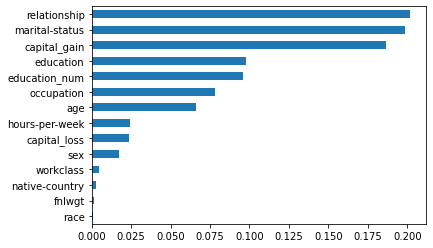

In [12]:
def plot_feature_importance(config, *args, **kwargs):
    fi = pd.Series(mte_config.model.feature_importances_, index=mte_config.categoricals + mte_config.numericals).sort_values()
    fi.plot.barh(*args, **kwargs)
    plt.show()


plot_feature_importance(mte_config)

In [13]:
# number of unique values for each categorical column
{col: df[col].nunique() for col in categoricals}

{'workclass': 9,
 'education': 16,
 'marital-status': 7,
 'occupation': 15,
 'relationship': 6,
 'race': 5,
 'sex': 2,
 'native-country': 42}